# Calculating variance explained by various metadata in healthy reference
### level_2_annot, all ages (including fetal)
based on this notebook from HLCA: https://github.com/LungCellAtlas/HLCA_reproducibility/blob/main/notebooks/2_downstream_analysis_of_HLCA_core/01_variance_contribution_of_tech_and_bio_covariates.ipynb

Extended data 3b

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.gridspec import GridSpec
import seaborn as sns
import sys
import os
import copy
#from adjustText import adjust_text

sys.path.append("/nfs/team205/ao15/Megagut/Annotations_v3/healthy_analysis/HLCA_scripts")
import utils
import analysis

from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import entropy

In [2]:
sc.logging.print_header()

scanpy==1.8.0 anndata==0.8.0 umap==0.4.6 numpy==1.20.1 scipy==1.6.1 pandas==1.3.5 scikit-learn==0.24.1 statsmodels==0.13.5 python-igraph==0.8.3 louvain==0.7.0 leidenalg==0.8.3 pynndescent==0.5.2


In [3]:
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

In [70]:
dir_results = "/nfs/team205/ao15/Megagut/Annotations_v3/healthy_analysis/variance_analysis/level_2_annot_all_ages/"
dir_figures = "/nfs/team205/ao15/Megagut/Annotations_v3/healthy_analysis/variance_analysis/level_2_annot_all_ages/figures/"

In [5]:
adata = sc.read_h5ad('/nfs/team205/ao15/Megagut/Annotations_v3/h5ad/pooled_healthy.no_doublets.annot_all_levels.updated_donorID.20230126.h5ad')

In [6]:
adata

AnnData object with n_obs × n_vars = 1077241 × 36601
    obs: 'latent_cell_probability', 'latent_RT_efficiency', 'cecilia22_predH', 'cecilia22_predH_prob', 'cecilia22_predH_uncertain', 'cecilia22_predL', 'cecilia22_predL_prob', 'cecilia22_predL_uncertain', 'elmentaite21_pred', 'elmentaite21_pred_prob', 'elmentaite21_pred_uncertain', 'suo22_pred', 'suo22_pred_prob', 'suo22_pred_uncertain', 'n_counts', 'log1p_n_counts', 'n_genes', 'log1p_n_genes', 'percent_mito', 'n_counts_mito', 'percent_ribo', 'n_counts_ribo', 'percent_hb', 'n_counts_hb', 'percent_top50', 'n_counts_raw', 'log1p_n_counts_raw', 'n_genes_raw', 'log1p_n_genes_raw', 'percent_mito_raw', 'n_counts_mito_raw', 'percent_ribo_raw', 'n_counts_ribo_raw', 'percent_hb_raw', 'n_counts_hb_raw', 'percent_top50_raw', 'n_counts_spliced', 'log1p_n_counts_spliced', 'n_genes_spliced', 'log1p_n_genes_spliced', 'percent_mito_spliced', 'n_counts_mito_spliced', 'percent_ribo_spliced', 'n_counts_ribo_spliced', 'percent_hb_spliced', 'n_counts_hb_s

In [7]:
covariates = [
    "study",
    "tissue_fraction",
    "cell_fraction_unified",
    "cell_sorting",
    "log1p_n_counts",
    "percent_mito",
    "technology",
    "sample_type",
    "sample_category",
    "sample_retrieval",
    "sex",
    "donor_disease",
    "donorID_unified",
    "organ_unified",
    "age_unified",
]

In [8]:
for cov in covariates:
    if type(adata.obs[cov].values) == pd.Categorical:
        print(cov.upper())
        print(set(adata.obs[cov]))
        print("\n")
    else:
        print(cov.upper(), "not a categorical.\n")

STUDY
{'Elmentaite2021', 'Wang2020', 'Uzzan2022', 'Yu2021', 'Huang2019', 'Parikh2019', 'Li2019', 'CostaDaSilva2022', 'Lee2020', 'Chen2021', 'CBTM_unpublished', 'Williams2021', 'Madissoon2019', 'Pagella2021', 'Dominguez2022', 'James2020', 'Martin2019', 'Jeong2021', 'Kinchen2018', 'Kim2022', 'Caetano2021', 'He2020GenomeBio', 'Jaeger2021', 'Newcastle_unpublished', 'Holloway2021'}


TISSUE_FRACTION
{'Epithelium', 'Lamina_propria', 'Full_thickness', 'Mucosa'}


CELL_FRACTION_UNIFIED
{'CD45_PNequalpool_FACS', 'EPCAMN_MACS', 'SC-EPCAMP', 'Live_FACS', 'CD3P_FACS', 'nan', 'Total', 'Live_MACS', 'CD45P_CD3N_CD19N_FACS', 'Unclear', 'CD45N_FACS', 'CD45N_MACS', 'CD4P_FACS', 'CD45P_FACS', 'Ficoll_percoll', 'CD45_PNequalpool_MACS', 'CD45P_MACS', 'EPCAMP_MACS', 'Stromal_MACS'}


CELL_SORTING
{'Density', 'FACS', 'MACS', 'nan', 'None'}


LOG1P_N_COUNTS not a categorical.

PERCENT_MITO not a categorical.

TECHNOLOGY
{'10X_3pv2', '10X_3pv3', '10X_5p'}


SAMPLE_TYPE
{'Organ_donor_resection', 'Live_biopsy', 

In [9]:
#need to harmonise CELL_FRACTION_UNIFIED, SAMPLE_CATEGORY
adata.obs['cell_fraction_unified'] = (adata.obs["cell_fraction_unified"].map(lambda x: {
 
    'SC-EPCAMP':'EPCAMP_FACS', 
    'Unclear':'nan', 
        
         }.get(x, x)).astype("category"))

In [10]:
adata.obs['cell_fraction_unified'].value_counts()

Total                    525174
Ficoll_percoll           117779
EPCAMP_MACS               77337
Live_FACS                 57807
CD45P_MACS                49365
CD3P_FACS                 34344
Live_MACS                 34095
CD45P_FACS                32775
nan                       26643
EPCAMN_MACS               25817
CD45N_MACS                23560
CD45_PNequalpool_FACS     22272
CD45P_CD3N_CD19N_FACS     13763
CD4P_FACS                 12436
Stromal_MACS               8634
CD45_PNequalpool_MACS      6632
CD45N_FACS                 6021
EPCAMP_FACS                2787
Name: cell_fraction_unified, dtype: int64

In [11]:
#need to harmonise CELL_FRACTION_UNIFIED, SAMPLE_CATEGORY
adata.obs['sample_category'] = (adata.obs["sample_category"].map(lambda x: {
 'Neighbouring_inflammed':'Neighbouring_inflamed'
    
        
         }.get(x, x)).astype("category"))

In [12]:
adata.obs['sample_category'].value_counts()

Non_pathological         849886
Neighbouring_cancer      133968
Neighbouring_inflamed     85364
Neighbouring_polyps        8023
Name: sample_category, dtype: int64

In [13]:
adata.obs['donor_disease'] = (adata.obs["donor_disease"].map(lambda x: {
 'SCC_mandibular_gingiva ':'SCC_mandibular_gingiva'
    
        
         }.get(x, x)).astype("category"))


In [14]:
covariates = [
    "study",
    "tissue_fraction",
    "cell_fraction_unified",
    "cell_sorting",
    "log1p_n_counts",
    "percent_mito",
    "technology",
    "sample_type",
    "sample_category",
    "sample_retrieval",
    "sex",
    "donor_disease",
    "donorID_unified",
    "organ_unified",
    "age_unified",
]

In [15]:
for cov in covariates:
    if type(adata.obs[cov].values) == pd.Categorical:
        print(cov.upper())
        print(set(adata.obs[cov]))
        print("\n")
    else:
        print(cov.upper(), "not a categorical.\n")

STUDY
{'Elmentaite2021', 'Wang2020', 'Uzzan2022', 'Yu2021', 'Huang2019', 'Parikh2019', 'Li2019', 'CostaDaSilva2022', 'Lee2020', 'Chen2021', 'CBTM_unpublished', 'Williams2021', 'Madissoon2019', 'Pagella2021', 'Dominguez2022', 'James2020', 'Martin2019', 'Jeong2021', 'Kinchen2018', 'Kim2022', 'Caetano2021', 'He2020GenomeBio', 'Jaeger2021', 'Newcastle_unpublished', 'Holloway2021'}


TISSUE_FRACTION
{'Epithelium', 'Lamina_propria', 'Full_thickness', 'Mucosa'}


CELL_FRACTION_UNIFIED
{'CD4P_FACS', 'Live_FACS', 'CD3P_FACS', 'CD45P_FACS', 'Ficoll_percoll', 'CD45_PNequalpool_MACS', 'CD45N_FACS', 'EPCAMP_FACS', 'CD45N_MACS', 'nan', 'Total', 'CD45P_MACS', 'Live_MACS', 'CD45P_CD3N_CD19N_FACS', 'CD45_PNequalpool_FACS', 'EPCAMP_MACS', 'EPCAMN_MACS', 'Stromal_MACS'}


CELL_SORTING
{'Density', 'FACS', 'MACS', 'nan', 'None'}


LOG1P_N_COUNTS not a categorical.

PERCENT_MITO not a categorical.

TECHNOLOGY
{'10X_3pv2', '10X_3pv3', '10X_5p'}


SAMPLE_TYPE
{'Organ_donor_resection', 'Live_biopsy', 'Live_res

In [16]:
min_n_cells_total = 50  # in total
min_n_cells = 10  # per sample
min_n_samples = 2

In [17]:
outdir_1 = os.path.join(dir_results, f"variance_explained_fractions/")
if not os.path.exists(outdir_1):
    print("Creating directory:", outdir_1)
    os.makedirs(outdir_1)
outdir_2 = os.path.join(dir_results, f"samples_included/")
if not os.path.exists(outdir_2):
    print("Creating directory:", outdir_2)
    os.mkdir(outdir_2)


In [18]:
if not False:
    print("yes")

yes


In [19]:
int_types = ["integrated"]  # list needs to include "integrated" and/or "unintegrated"

/home/jovyan/my-conda-envs/standard_plotting/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


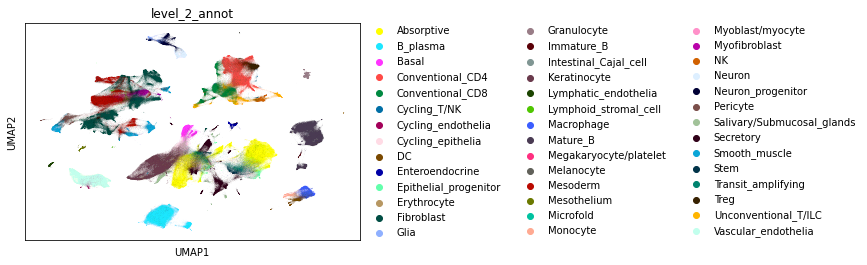

In [20]:
sc.pl.umap(adata,color='level_2_annot')

In [21]:
adata.obs['level_2_annot'] = adata.obs['level_2_annot'].str.replace("/", "_")

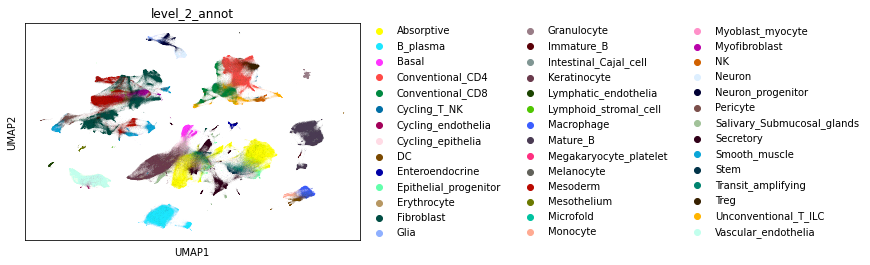

In [22]:
sc.pl.umap(adata,color='level_2_annot')

In [23]:
adata.obs.level_2_annot.unique()

['Vascular_endothelia', 'Granulocyte', 'DC', 'Monocyte', 'Basal', ..., 'Neuron', 'Intestinal_Cajal_cell', 'Epithelial_progenitor', 'Mesothelium', 'Myoblast_myocyte']
Length: 42
Categories (42, object): ['Absorptive', 'B_plasma', 'Basal', 'Conventional_CD4', ..., 'Transit_amplifying', 'Treg', 'Unconventional_T_ILC', 'Vascular_endothelia']

In [24]:
#need to fix none in cell_sorting, otherwise it will be classed as nan
adata.obs['cell_sorting'] = (adata.obs["cell_sorting"].map(lambda x: {
 'None':'No_sorting'
        
         }.get(x, x)).astype("category"))

In [25]:
print(type(adata.obsm['X_scvi']))

<class 'pandas.core.frame.DataFrame'>


In [26]:
#convert from dataframe to array
adata.obsm['X_scvi'] = adata.obsm['X_scvi'].values.copy()

In [27]:
# Initiate a dictionary, in which we will store which samples were included per
# single regression
samples_included = dict()
cts_to_skip = list()  # we will fill this with cts that have too few samples
# these samples should be skipped in the rest of the analysis.
# Loop through specified integration types:
for int_type in int_types:
    samples_included[int_type] = dict()
    # loop through all annotations (= cell types), and also include the entire
    # atlas as a "cell type":
    for subset in sorted(adata.obs.level_2_annot.unique()) + ["whole_atlas"]:
        # remove slash from cell type name, for file storing etc.
        subset_no_space = subset.replace(" ", "_")
        # initiate a dataframe, in which we will store for every covariate
        # which samples we include in the regression (we will exclude samples
        # that have no value available for the covariate under consideration
        # (e.g. BMI not recorded), as well as samples that have fewer than 10
        # cells of the cell type under consideration)
        samples_included[int_type][subset] = pd.DataFrame(
            index=adata.obs["sampleID"].unique(), columns=covariates
        )
        # if file doesn't exist yet (built in this check for if loop breaks halfway,
        # feel free to take it out):
        if not os.path.isfile(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            )
        ):
            print(f"Working on {int_type}, {subset}...")
            # select the correct cells:
            if subset == "whole_atlas":
                subadata = adata.copy()
                verbose = True
            elif subset not in adata.obs.level_2_annot.unique():
                raise ValueError(
                    "subset should be set either to 'Whole atlas' or to a category in your manual_ann grouped obs variable!"
                )
            else:
                subadata = adata[adata.obs.level_2_annot == subset, :].copy()
                verbose = False
            if subadata.n_obs < min_n_cells_total:
                print(f"{subset} has fewer than {min_n_cells_total} cells! Skipping.")
                cts_to_skip.append(subset)
                continue
            # select the right embedding:
            if int_type == "unintegrated":
                emb_name = "X_pca"
                sc.tl.pca(subadata, n_comps=n_pcs, use_highly_variable=True)
            elif int_type == "integrated":
                emb_name = "X_scvi"
            else:
                raise ValueError(
                    "emb_name should be set either to 'integrated' or 'unintegrated'"
                )
            # store the number of components in our embedding of choice
            n_comps = subadata.obsm[emb_name].shape[1]
            # initiate a dataframe in which we'll store the variance explained
            # by each covariate, plus the total variance ("overall") observed
            var_explained = pd.DataFrame(
                index=range(n_comps), columns=covariates + ["overall"]
            )
            # initiate a dataframe in which we will store the data
            # for our linear regression (i.e. the PC/latent components, + covariates).
            # Rows are cells, but we will collapse this to samples below
            comp_sample_df = pd.DataFrame(index=subadata.obs.index)
            comp_sample_df["sampleID"] = subadata.obs["sampleID"]
            # prepare aggregation dictionary for collapsing into sample-wise
            # observations
            agg_dict = {"sampleID": "count"}  # this will be number of cells
            for comp in range(n_comps):
                # store component scores per cell
                comp_sample_df[f"comp{comp}"] = subadata.obsm[emb_name][:, comp]
                # we will aggregate these later by taking the mean per sample
                agg_dict[f"comp{comp}"] = "mean"
            for cov in covariates:
                if cov in ["log1p_n_counts", "percent_mito"]:
                    # store values
                    comp_sample_df[cov] = subadata.obs[cov]
                    # we will aggregate by taking the mean
                    agg_dict[cov] = "mean"
                else:
                    # for all other covariates: these are sample-level
                    # covariates, so we will take the "first" overservation
                    # in the sample (which should be the only)
                    comp_sample_df[cov] = subadata.obs[cov]
                    agg_dict[cov] = "first"
            # now collapse into sample-level observations
            sample_df = (
                comp_sample_df.groupby("sampleID")
                .agg(agg_dict)
                .rename(columns={"sampleID": "n_cells"})
            )
            # filter out samples with fewer than min_n_cells cells of the cell type
            sample_df = sample_df.loc[
                sample_df.n_cells >= min_n_cells,
            ].copy()
            # check number of samples left.
            # If fewer than min_n_samples remain, we will skip the cell type
            if sample_df.shape[0] < min_n_samples:
                print(
                    f"Only {sample_df.shape[0]} samples available for {subset}. Skipping."
                )
                cts_to_skip.append(subset)
                continue
            # Otherwise, move on to the linear regression:
            # do a linear regression on each component, with the component scores
            # as response variable...
            for comp in range(n_comps):
                # store the component values (for all samples i.e. unfiltered)
                y_true_unfiltered = sample_df.loc[:, f"comp{comp}"].values
                # and store variance of y_true as "overall" variance
                var_explained.loc[f"comp{comp}", "overall"] = np.var(y_true_unfiltered)
                # and the covariate as fixed variable
                for cov in covariates:
                    # store covariate observations under x
                    x = sample_df[cov].values.copy()
                    # store samples to which they match
                    x_samples = sample_df.index
                    # check which of these samples have no observation (e.g.
                    # because BMI was unknown, or age, etc.)
                    # (the function used below checks for different kinds of
                    # nas, e.g. np.nan, "nan", None, "None" etc.)
                    x_nans = np.vectorize(utils.check_if_nan)(x)
                    # now keep only xs that have real observations
                    x = x[~x_nans]
                    # if only one or no observations are left, skip this covariate
                    if len(x) < 2:
                        continue
                    # filter samples according to x filtering
                    x_samples = x_samples[~x_nans]
                    # and store which samples were included in our samples_included
                    # dictionary, for later reference (this is our "n")
                    samples_included[int_type][subset][cov] = samples_included[
                        int_type
                    ][subset].index.isin(x_samples.tolist())
                    # filter y_true according to x's filtering
                    y_true = y_true_unfiltered[~x_nans].reshape(-1, 1)
                    # prepare x for linear regression:
                    # if it is a float (e.g. BMI, age), all we need to do is reshape:
                    if x.dtype in ["float32", "float", "float64"]:
                        x = x.reshape(-1, 1)
                        # print that we are treating as numerical (only for first comp,
                        # so that we don't print the same thing many times)
                        if comp == 0 and verbose:
                            print(f"treating {cov} as continuous variable")
                    # otherwise we are dealing with a categorical...
                    else:
                        # if it has only one category, there is 0 variance and
                        # we cannot perform linear regression. In that case,
                        # move on to the next covariate.
                        if len(set(x)) == 1:
                            var_explained.loc[comp, cov] = np.nan
                            continue
                        # Otherwise, convert x to dummied variable:
                        # print that we are converting to dummy
                        # (only do it for the first comp, otherwise we print the same thing
                        # many times)
                        if comp == 0 and verbose:
                            print(f"converting {cov} to dummy variable")
                        # drop_first means we ensure that are x is full rank,
                        # and we only encode all-1 categories
                        x = pd.get_dummies(x, drop_first=True)
                    # now perform linear regression
                    lrf = LinearRegression(fit_intercept=True).fit(
                        x,
                        y_true,
                    )
                    # predict y based on the fit linear model
                    y_pred = lrf.predict(x)
                    # and store the variance of the predicted y, this is the
                    # "variance explained" by the covariate, for this component
                    var_explained.loc[comp, cov] = np.var(y_pred)
            # for each covariate, sum up how much variance it explains across
            # the components (i.e. PCs or scANVI latent components)
            # Sort covariates from explaining most to explaining least
            total_variance_explained = np.sum(var_explained, axis=0).sort_values(
                ascending=False
            )
            # divide this by the total variance that was observed in the
            # components, to get fraction of variance explained
            total_variance_explained_fractions = (
                total_variance_explained / total_variance_explained["overall"]
            )
             # write to files:
            # 1) variance explained fractions, for this integration type and cell type
            total_variance_explained_fractions.to_csv(
                os.path.join(
                    dir_results,
                    f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
                )
            )
            # 2) samples included, for this cell type
            samples_included[int_type][subset].to_csv(
                os.path.join(
                    dir_results,
                    f"samples_included/samples_included_{subset_no_space}.csv",
                )
            )

Working on integrated, Erythrocyte...
Only 1 samples available for Erythrocyte. Skipping.
Working on integrated, Megakaryocyte_platelet...
Megakaryocyte_platelet has fewer than 50 cells! Skipping.


### Plot variance explained results (Supplementary figure):

In [28]:
int_type = "integrated" # we used integrated in the paper, not unintegrated

In [29]:
cts_to_skip

['Erythrocyte', 'Megakaryocyte_platelet']

In [30]:
subsets = ["whole_atlas"] + sorted(adata.obs.level_2_annot.unique())
# import variance explained fractions for the Whole atlas, to get indices
# and columns for dataframes
vef_df = pd.read_csv(
    os.path.join(
        dir_results,
        f"variance_explained_fractions/variance_explained_fractions_whole_atlas_{int_type}.csv",
    ),
    index_col=0,
).rename(columns={"0": "uncorrected"})
# inititate empty dataframes for variance explained fractions
vars_expl = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip], columns=vef_df.index
)
# initiate an empty dictionary to store samples included for each cell type - cov
# pair
samples_included = dict()
# loop through cell types + Whole atlas
for subset in subsets:
    if subset not in cts_to_skip:
        # replace spaces in cell type name with "_" for file writing etc.
        subset_no_space = subset.replace(" ", "_")
        # import variance explained fractions:
        vef_df = pd.read_csv(
            os.path.join(
                dir_results,
                f"variance_explained_fractions/variance_explained_fractions_{subset_no_space}_{int_type}.csv",
            ),
            index_col=0,
        ).rename(columns={"0": "uncorrected"})
        # store values in our overview dataframes
        vars_expl.loc[subset, vef_df.index] = vef_df.values.reshape(1, -1)
        # store which samples were included for each covariate based on matching file
        samples_included[subset] = pd.read_csv(
            os.path.join(
                dir_results, f"samples_included/samples_included_{subset_no_space}.csv"
            ),
            index_col=0,
        )
# rename "whole_atlas" to "Whole atlas" index, for prettier plotting
vars_expl.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [31]:
# collect categorical covariates...
cat_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    not in [
        "float32",
        "float",
        "float64",
    ]
]
# and continuous/numerical covariates
cont_covs = [
    cat
    for cat in covariates
    if adata.obs[cat].values.dtype
    in [
        "float32",
        "float",
        "float64",
    ]
]

In [32]:
print(cat_covs)

['study', 'tissue_fraction', 'cell_fraction_unified', 'cell_sorting', 'technology', 'sample_type', 'sample_category', 'sample_retrieval', 'sex', 'donor_disease', 'donorID_unified', 'organ_unified', 'age_unified']


In [33]:
print(cont_covs)

['log1p_n_counts', 'percent_mito']


In [34]:
# aggregate values by sample
agg_dict = {cov: "first" for cov in cat_covs}  # use "first" for categorical
agg_dict.update({cov: "mean" for cov in cont_covs})  # and "mean" for continuous
# collect statistics:
sample_df = adata.obs.groupby("sampleID").agg(agg_dict)
# initiate dataframe where we store for every cell type, for every covariate,
# how many unique values are observed
n_cats_per_cov = pd.DataFrame(
    index=[subs for subs in subsets if subs not in cts_to_skip],
    columns=cat_covs + cont_covs + ["sampleID"],
)
# loop through cell types and categorical covariates
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cat_covs:
            # annotation will always be one (this might change if we set our
            # cell type variable differently!)
            if cov == "level_2_annot":
                n_cats_per_cov[cov] = 1
            else:
                # extract covariate values only for samples included for cell type
                # and covariate
                sample_df_subset = sample_df.loc[
                    samples_included[subset].index[samples_included[subset][cov]], :
                ].copy()
                # count number of unique values
                n_per_cov = sample_df_subset[cov].nunique()
                # store
                n_cats_per_cov.loc[subset, cov] = n_per_cov
        # store number of samples included as the maximum number of samples included,
        # across covariates, for a cell type
        n_cats_per_cov.loc[subset, "sampleID"] = (
            samples_included[subset].sum(axis=0).max()
        )

# now create boolean df indicating in which cases only one unique value
# was observed for a cell type covariate pair
nis1 = n_cats_per_cov == 1
nis1.index = list(nis1.index)
nis1.loc["Whole atlas", :] = [
    adata.obs[cat_cov].nunique() == 1 for cat_cov in nis1.columns
]
#  now loop through continuous covariates and calculate variance instead of number
# of unique variables. If variance is 0, set nis1 to True.
for subset in subsets:
    if subset not in cts_to_skip:
        for cov in cont_covs:
            sample_df_subset = sample_df.loc[
                samples_included[subset].index[
                    (samples_included[subset].sum(axis=1) > 0)
                ],
                :,
            ].copy()
            variance = np.var(sample_df_subset[cov])
            if variance == 0 or np.isnan(variance):
                nis1.loc[subset, cov] = True
            else:
                nis1.loc[subset, cov] = False
nis1["overall"] = False

In [35]:
n_samples_included_df = pd.DataFrame(index=samples_included.keys(), columns=covariates)
for ct, samp_incl in samples_included.items():
    n_samples_included_df.loc[ct, :] = samp_incl.loc[:, covariates].sum(axis=0)

In [36]:
cts_ordered = [
    ct
    for ct in n_cats_per_cov.sort_values(by="sampleID", ascending=False).index.tolist()
    if ct != "whole_atlas"
]

In [37]:
# specify technical covariates to show
technical_covariates = [
      "study",
    "tissue_fraction",
    "cell_fraction_unified",
    "cell_sorting",
    "log1p_n_counts",
    "percent_mito",
    "technology",
     "sample_type",
    "sample_category",
    "sample_retrieval",
]
# specify bio covariates to show
bio_covariates = [
    
    "sex",
    "donor_disease",
    "donorID_unified",
    "organ_unified",
    "age_unified",
]
# order covariates by how much varaince they explain in the Whole atlas,
# in the integrated embedding (but keep technical vs bio distinction)
vars_expl.sort_values(by="Whole atlas", axis=1, ascending=False, inplace=True)
technical_covariates = [cov for cov in vars_expl.columns if cov in technical_covariates]
bio_covariates = [cov for cov in vars_expl.columns if cov in bio_covariates]
# now re-order vars_expl:
vars_expl = vars_expl.loc[
    ["Whole atlas"] + cts_ordered,
    technical_covariates + bio_covariates,
]

In [38]:
vars_expl_to_plot = vars_expl.copy()
# add capitalization
col_remapper = {
    col: (" ".join(col.replace("_", " ").split(" "))).capitalize()
    for col in vars_expl.columns
}

# We re-name some of the categories for clarity in the paper:
renaming = {
    "study":'Study',
    "tissue_fraction":'Tissue fraction',
    "cell_fraction_unified":'Cell fraction',
    "cell_sorting":'Cell sorting',
    "log1p_n_counts":'UMI count per cell',
    "percent_mito":'Percent mitochondrial genes',
    "technology":'10X technology',
     "sample_type":'Tissue sampling method (broad)',
    "sample_category":'Type of control tissue',
    "sample_retrieval":'Tissue sampling method (specific)',
      "sex":'Sex',
    "donor_disease":'Disease status of donor',
    "donorID_unified":'Donor ID',
    "organ_unified":'Organ',
    "age_unified":'Age',
}
col_remapper.update(renaming)
# now rename:
vars_expl_to_plot.rename(columns=col_remapper, inplace=True)

In [39]:
# store mask for cell type - covariate pairs with fewer than 40 samples included
mask1 = (
    n_samples_included_df.loc[
        ["whole_atlas"] + vars_expl.index[1:].tolist(),
        vars_expl.columns,
    ]
    < 40
)

In [40]:
# store mask for cell type - covariate pairs for which only 1 unique value
# was observed
mask2 = nis1.loc[
    ["whole_atlas"] + vars_expl.index[1:].tolist(),
    vars_expl.columns,
]

In [41]:
# combine masks
mask_overall = mask1 | mask2
# rename Whole atlas
mask_overall.rename(index={"whole_atlas": "Whole atlas"}, inplace=True)

In [42]:
if "dataset" in mask_overall.columns:
    mask_overall.drop(columns="dataset", inplace=True)
mask_overall.rename(columns=col_remapper, inplace=True)

In [43]:
n_non_masked_rows = mask_overall.shape[0] - (mask_overall == True).sum(axis=0)
columns_to_drop = n_non_masked_rows.loc[n_non_masked_rows < 5].index.tolist()

In [44]:
columns_to_drop

[]

In [45]:
FIGURES = dict()

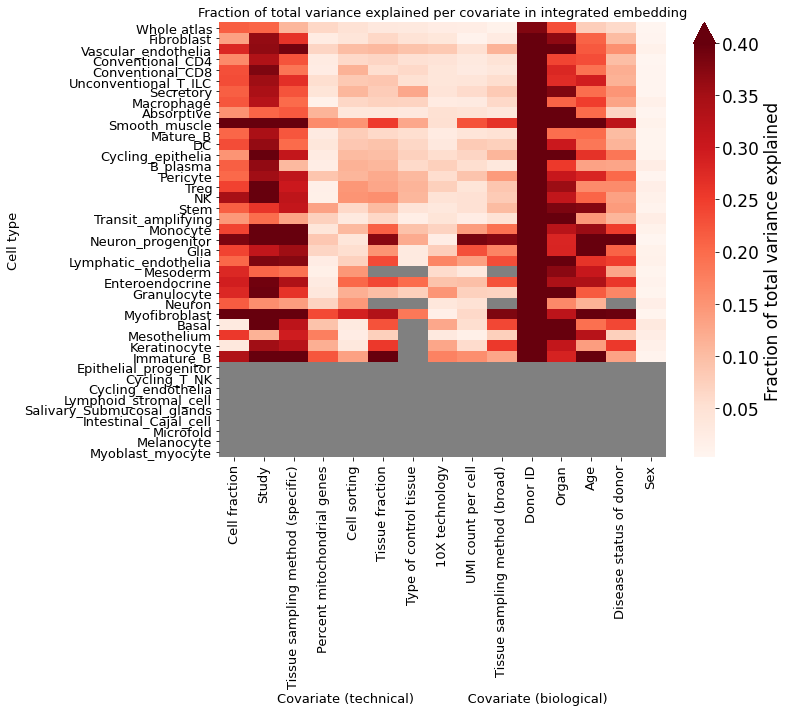

In [46]:
fz = 13  # fontsize
cmap = copy.copy(cm.get_cmap("Reds"))  # select color map
cmap.set_bad("grey")  # set masked color to grey instead of white
fig, ax = plt.subplots(figsize=(10, 8))  # figsize
vmax = 0.4
title = "Fraction of total variance"
# for file storing:
title_no_spaces = title.replace(" ", "_")
sns.heatmap(
    vars_expl_to_plot.astype(float),
    ax=ax,
    vmax=vmax,
    cbar_kws={"extend": "max"},
    mask=mask_overall.loc[vars_expl_to_plot.index, vars_expl_to_plot.columns].values,
    cmap=cmap,
)
ax.collections[0].colorbar.set_label(f"{title} explained", fontsize=fz + 4)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize=fz)
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize=fz)
plt.title(
    f"{title} explained per covariate in integrated embedding",
    fontsize=fz,
)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=fz + 4)
plt.xlabel("Covariate (technical)             Covariate (biological)", fontsize=fz)
plt.ylabel("Cell type", fontsize=fz)
plt.show()
plt.close()
FIGURES[f"supplementary{title_no_spaces}_explained_per_covariate_{int_type}_emb"] = fig

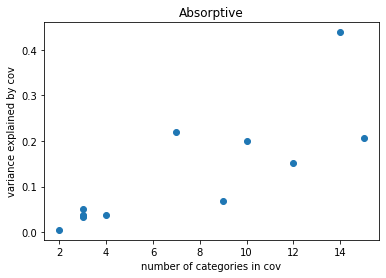

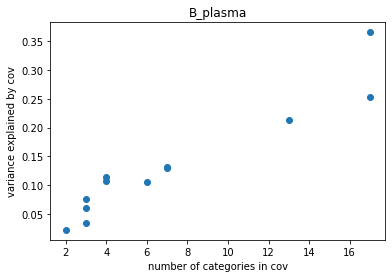

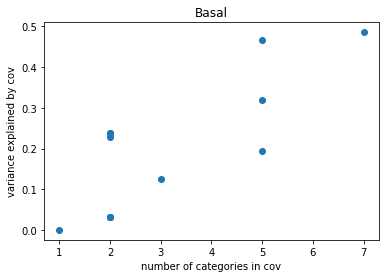

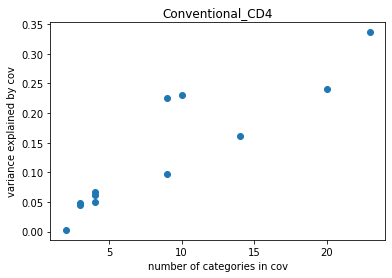

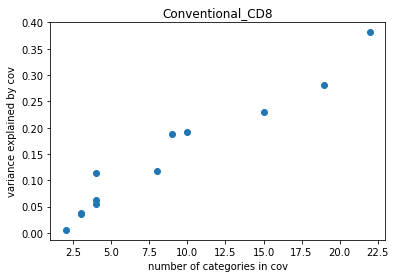

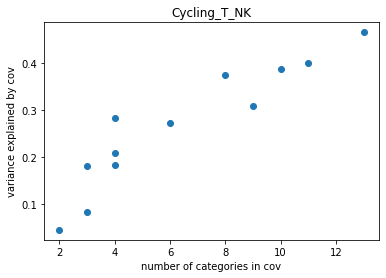

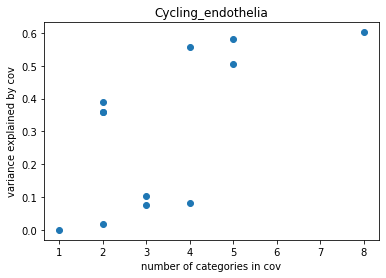

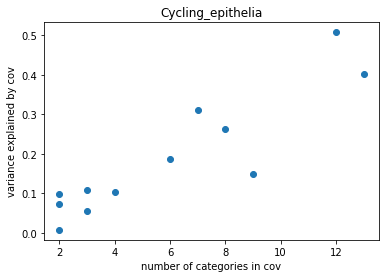

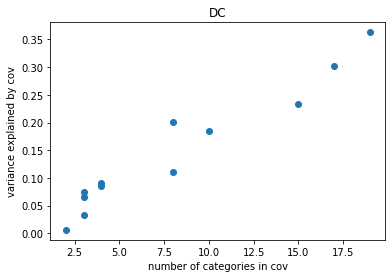

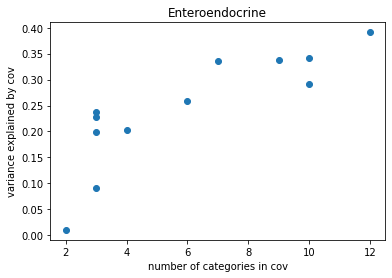

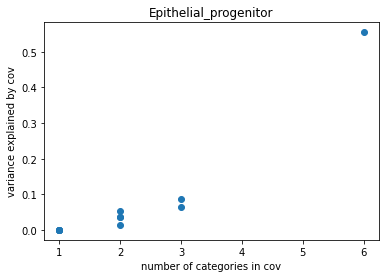

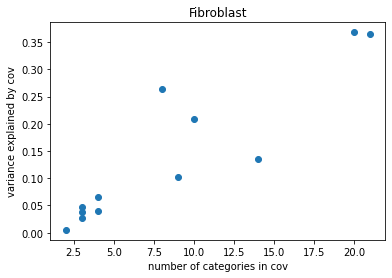

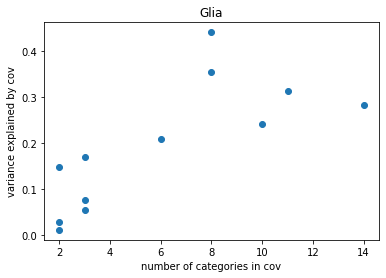

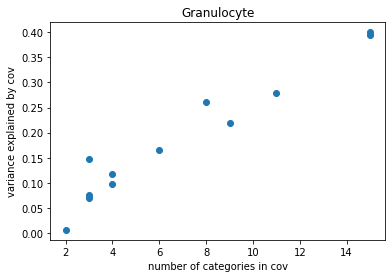

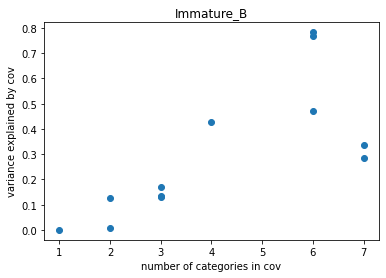

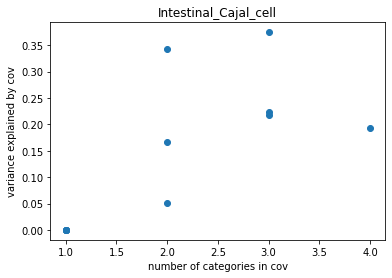

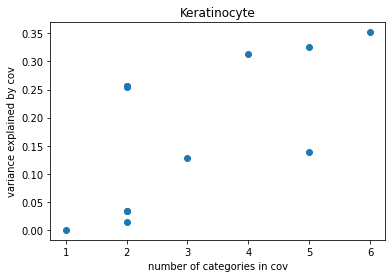

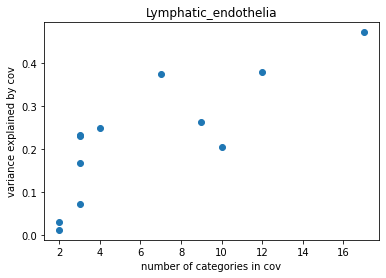

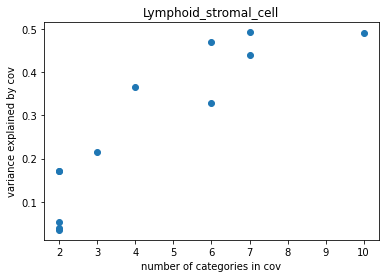

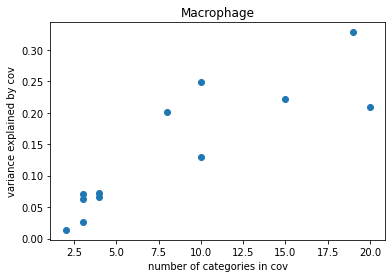

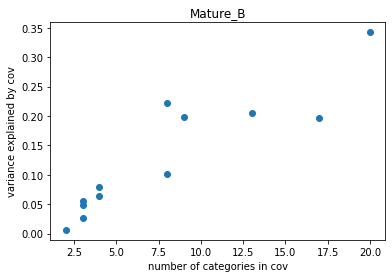

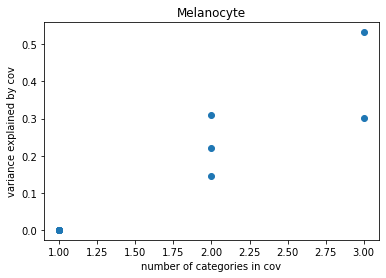

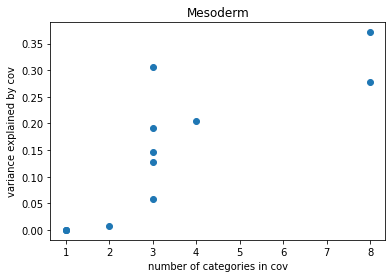

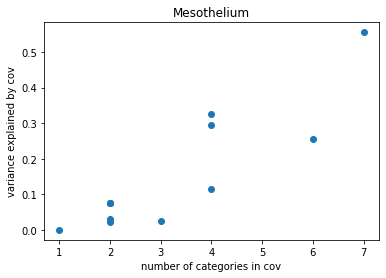

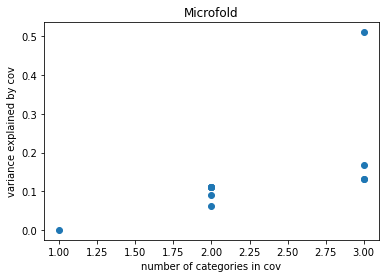

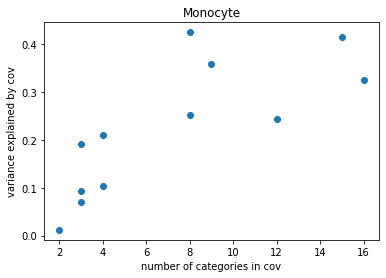

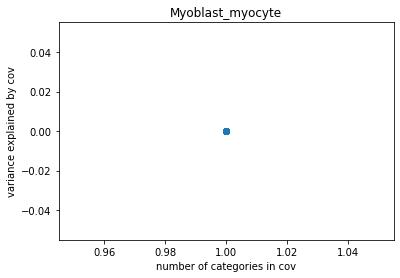

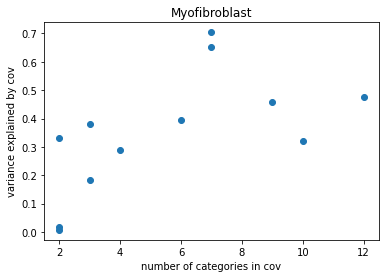

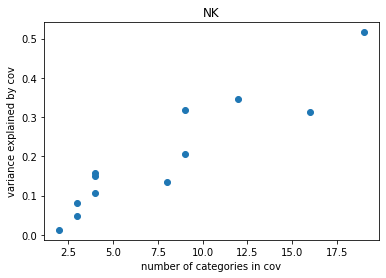

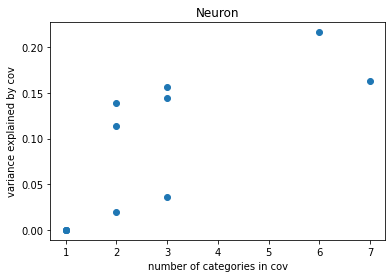

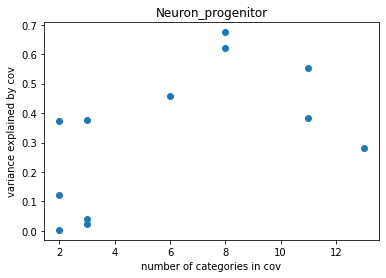

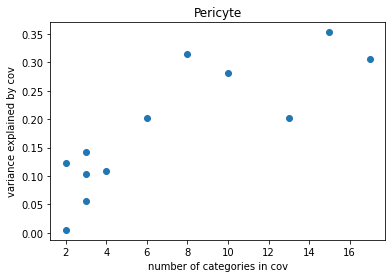

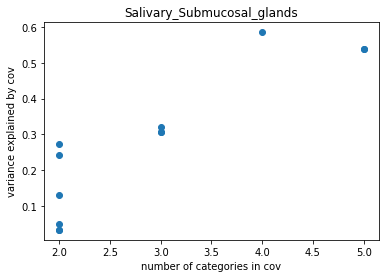

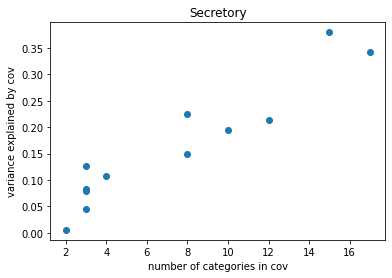

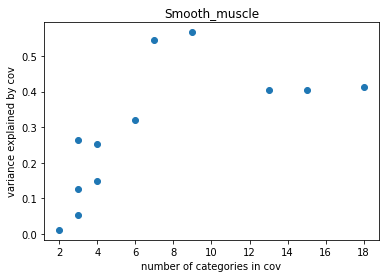

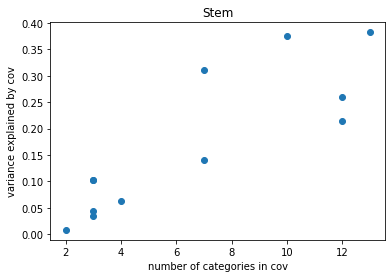

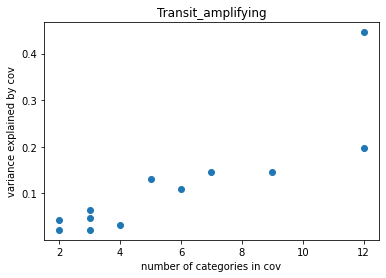

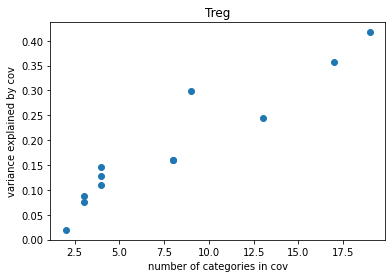

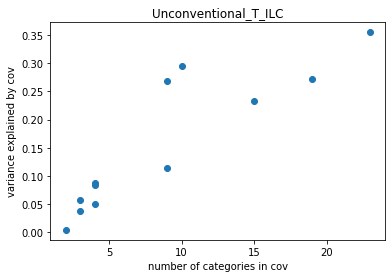

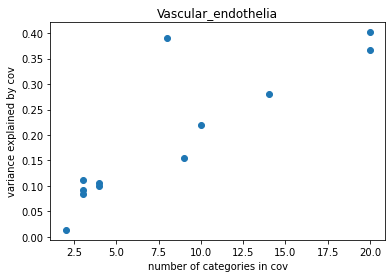

In [47]:
for subset in subsets:
    if subset not in cts_to_skip:
        cols = [col for col in cat_covs if col not in ["donorID_unified", "level_2_annot"]]
        if subset not in "whole_atlas":
            plt.scatter(n_cats_per_cov.loc[subset, cols], vars_expl.loc[subset, cols])
            plt.xlabel("number of categories in cov")
            plt.ylabel("variance explained by cov")
            plt.title(subset)
            plt.show()

In [48]:
mean_var_expl = pd.DataFrame(index=vars_expl_to_plot.index)

In [49]:
mean_var_expl["bio"] = vars_expl_to_plot.loc[
    :,
    [
        col
        for col in vars_expl_to_plot.columns
        if col in [col_remapper[cov] for cov in bio_covariates]
    ],
].mean(axis=1)

In [50]:
mean_var_expl["tech"] = vars_expl_to_plot.loc[
    :,
    [
        col
        for col in vars_expl_to_plot.columns
        if col in [col_remapper[cov] for cov in technical_covariates]
    ],
].mean(axis=1)
mean_var_expl["overall"] = vars_expl_to_plot.mean(axis=1)
# mean_var_expl["ct"] = vars_expl_to_plot.index

In [51]:
from adjustText import adjust_text

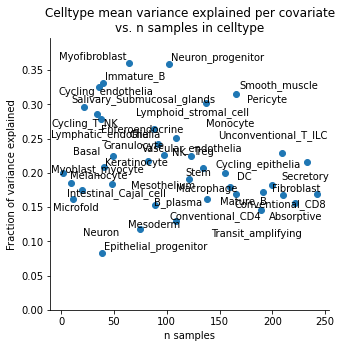

In [57]:
x = n_cats_per_cov.loc[cts_ordered, "sampleID"]
y = mean_var_expl.loc[cts_ordered, "overall"]
fz = 10
with plt.rc_context(
    {
        "figure.figsize": (5, 5),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    ax.scatter(x, y)
    ax.set_ylim((0, 1.1 * np.max(y)))
    texts = [
        plt.text(x[ct], y[ct], ct)
        for ct in x.index
        if x[ct] < 400 and y[ct] > 0
    ]
    adjust_text(texts)
    ax.set_xlabel("n samples")
    ax.set_ylabel("Fraction of variance explained")

    ax.set_title(
        "Celltype mean variance explained per covariate\nvs. n samples in celltype"
    )
    plt.show()
    FIGURES["_mean_var_expl_per_cov_ct_vs_nsample"] = fig

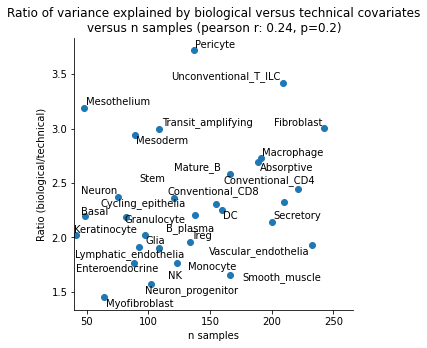

In [56]:
with plt.rc_context(
    {
        "figure.figsize": (5, 5),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = n_cats_per_cov.loc[cts_ordered, "sampleID"]
    y = mean_var_expl.loc[cts_ordered, "bio"] / mean_var_expl.loc[cts_ordered, "tech"]
    # remove celltypes with n_samples < 40
    filt = x > 40
    x = x[filt]
    y = y[filt]
    # calculate pearson correlation
    r, p = pearsonr(x, y)
    r = round(r, 2)
    p = round(p, 2)
    ax.scatter(x, y)
    ax.set_xlim((40, 1.1 * np.max(x)))
    texts = [
        plt.text(x[ct], y[ct], ct)
        for ct in x.index
        if x[ct] > 0 and y[ct] > 0.1
    ]
    adjust_text(texts)
    ax.set_xlabel("n samples")
    ax.set_ylabel("Ratio (biological/technical)")

    ax.set_title(
        f"Ratio of variance explained by biological versus technical covariates\nversus n samples (pearson r: {r}, p={p})"
    )
    plt.show()
    FIGURES["_bio_over_tech_var_explained_vs_nsamples"] = fig

In [59]:
cts_to_incl = n_cats_per_cov.index[n_cats_per_cov.loc[:, "sampleID"] > 40]
cts_to_incl = [ct for ct in cts_to_incl if ct != "whole_atlas"]

In [60]:
sampl_m_entropy_vs_var_expl = pd.DataFrame(
    index=cts_ordered,
    columns=["sampl_m_var_expl", "sampl_m_entr"],
)
sampl_m_entropy_vs_var_expl.sampl_m_var_expl = vars_expl_to_plot.loc[
    cts_ordered, "Tissue sampling method (specific)"
]

In [61]:
for ct in cts_ordered:
    # take only the samples that passed filtering in beginning of notebook
    # into account:
    sampl_ms = sample_df.loc[samples_included[ct].sample_type, "sample_type"]
    sampl_m_frequency = (
        sample_df.loc[samples_included[ct].sample_type, :]
        .groupby("sample_type")
        .agg({"sample_type": "count"})
    )
    entr_sample_m = entropy(sampl_m_frequency)
    sampl_m_entropy_vs_var_expl.loc[ct, "sampl_m_entr"] = entr_sample_m[0]

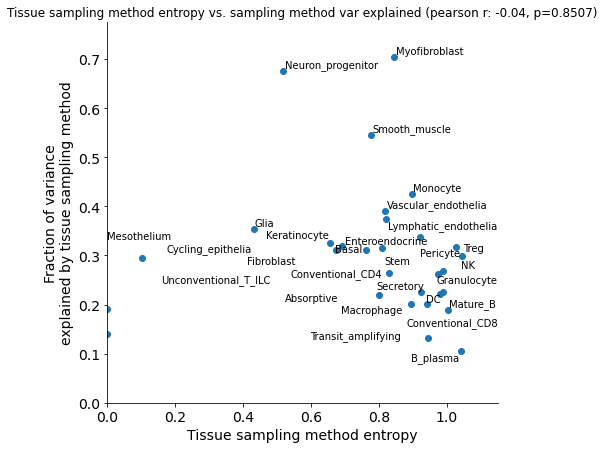

In [62]:
fz = 14
with plt.rc_context(
    {
        "figure.figsize": (7, 7),
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz - 4,
        "axes.spines.right": False,
        "axes.spines.top": False,
    }
):
    fig, ax = plt.subplots()
    x = sampl_m_entropy_vs_var_expl.sampl_m_entr
    y = sampl_m_entropy_vs_var_expl.sampl_m_var_expl
    n_samples_per_ct = n_cats_per_cov.loc[cts_ordered, "sampleID"]
    # remove celltypes with n_samples < 40
    filt = n_samples_per_ct > 40
    x = x[filt]
    y = y[filt]
    # calculate pearson correlation
    r, p = pearsonr(x, y)
    r = round(r, 2)
    p = round(p, 4)
    ax.scatter(x, y)
    ax.set_xlim((0, 1.1 * np.max(x)))
    ax.set_ylim((0, 1.1 * np.max(y)))
    texts = [
        plt.text(x[ct], y[ct], ct)
        for ct in x.index
        if x[ct] > 0 and y[ct] > 0  # 0.06
    ]
    adjust_text(texts)
    ax.set_xlabel("Tissue sampling method entropy")
    ax.set_ylabel("Fraction of variance\nexplained by tissue sampling method")

    ax.set_title(
        f"Tissue sampling method entropy vs. sampling method var explained (pearson r: {r}, p={p})"
    )
    plt.show()
    FIGURES["_sampl_meth_entr_vs_varexpl"] = fig

### Correlation between covariates (at sample level)

In [63]:
# filter aggregation dictionary that we'll use for summarizing stats per sample
# based on covariates included in main figure:
agg_dict_filt = dict()
for cov, agg_type in agg_dict.items():
    if cov in col_remapper.keys():
        if col_remapper[cov] in vars_expl_to_plot.columns:
            agg_dict_filt[cov] = agg_type

In [64]:
dir_results_cov_corrs = os.path.join(dir_results, "corr_between_covs")
if not os.path.exists(dir_results_cov_corrs):
    print("creating directory", dir_results_cov_corrs)
    os.makedirs(dir_results_cov_corrs)

In [65]:
# inititate empty dicts in which to store the final results per cell type
cov_corr_types_ct = dict()
cov_corrs_ct = dict()
# now loop through cell types:
for subset in ["whole_atlas"] + sorted(adata.obs.level_2_annot.unique()):
    if subset not in cts_to_skip:
        subset_no_spaces = subset.replace(" ", "_")  # for file names etc.
        # if file doesn't exist yet:
        if not os.path.isfile(
            os.path.join(
                dir_results_cov_corrs,
                f"{subset_no_spaces}_corrs_between_covariates_types.csv",
            )
        ):
            print(f"Working on {subset}...")
            # select the correct cells:
            if subset == "whole_atlas":
                subobs = adata.obs.copy()
                verbose = True
            elif subset not in adata.obs.level_2_annot.unique():
                raise ValueError(
                    "subset should be set either to 'whole_atlas' or to a category in your manual_ann_grouped obs variable!"
                )
            else:
                subobs = adata.obs.loc[adata.obs.level_2_annot == subset, :].copy()
                verbose = False
            # Store list with covariates to plot:
            covariates_to_plot = list(agg_dict_filt.keys())
            # iniate empty dataframes to store correlations and correlation types
            cov_corrs = pd.DataFrame(
                index=covariates_to_plot, columns=covariates_to_plot
            )
            cov_corr_types = pd.DataFrame(
                index=covariates_to_plot, columns=covariates_to_plot
            )
            # loop through covariates, and second loop through remaining covariates
            # (i.e. unique covariate pairs)
            cov1_count = 0
            for cov1_n, cov1 in enumerate(covariates_to_plot):
                for cov2 in covariates_to_plot[cov1_n:]:
                    # keep only data from the samples that were included in the
                    # analysis
                    samples_to_keep = [
                        s
                        for s, cov1_incl, cov2_incl in zip(
                            samples_included[subset].index,
                            samples_included[subset][cov1],
                            samples_included[subset][cov2],
                        )
                        if cov1_incl and cov2_incl
                    ]
                    subobs_filt = subobs.loc[
                        subobs["sampleID"].isin(samples_to_keep), :
                    ].copy()
                    # recategorize sample so that aggregation only happens for samples included:
                    subobs_filt["sampleID"] = subobs_filt[
                        "sampleID"
                    ].cat.remove_unused_categories()
                    # collapse to sample info:
                    subobs_sample_collapsed = subobs_filt.groupby("sampleID").agg(
                        agg_dict
                    )
                    # now calculate correlation/mutual information
                    subobs_sample_collapsed = subobs_filt
                    (
                        cov_corr_types.loc[cov1, cov2],
                        cov_corrs.loc[cov1, cov2],
                    ) = analysis.get_correlation_or_mi(
                        cov1, cov2, subobs_sample_collapsed, verbose=True
                    )
                cov1_count += 1
            # and store results
            cov_corr_types_ct[subset] = cov_corr_types
            cov_corr_types.to_csv(
                os.path.join(
                    dir_results_cov_corrs,
                    f"{subset_no_spaces}_corrs_between_covariates_types.csv",
                )
            )
            cov_corrs_ct[subset] = cov_corrs
            cov_corrs.to_csv(
                os.path.join(
                    dir_results_cov_corrs,
                    f"{subset_no_spaces}_corrs_between_covariates_values.csv",
                )
            )

Working on whole_atlas...
converting study to dummy variable
converting study to dummy variable
study: cat, study: cat, mutual info
converting study to dummy variable
converting tissue_fraction to dummy variable
study: cat, tissue_fraction: cat, mutual info
converting study to dummy variable
converting cell_fraction_unified to dummy variable
study: cat, cell_fraction_unified: cat, mutual info
converting study to dummy variable
converting cell_sorting to dummy variable
study: cat, cell_sorting: cat, mutual info
converting study to dummy variable
converting technology to dummy variable
study: cat, technology: cat, mutual info
converting study to dummy variable
converting sample_type to dummy variable
study: cat, sample_type: cat, mutual info
converting study to dummy variable
converting sample_category to dummy variable
study: cat, sample_category: cat, mutual info
converting study to dummy variable
converting sample_retrieval to dummy variable
study: cat, sample_retrieval: cat, mutual i

In [66]:
cov_corrs_ct = dict()
for subset in ["whole_atlas"] + sorted(adata.obs.level_2_annot.unique()):
    if subset not in cts_to_skip:
        subset_no_spaces = subset.replace(" ", "_")
        cov_corrs_ct[subset] = pd.read_csv(
            os.path.join(
                dir_results_cov_corrs,
                f"{subset_no_spaces}_corrs_between_covariates_values.csv",
            ),
            index_col=0,
        )

In [67]:
n_samples_per_ct = pd.Series(
    {
        subset: samples_included[subset].sum(axis=0).max()
        for subset in adata.obs.level_2_annot.unique()
        if subset not in cts_to_skip
    }
).sort_values()

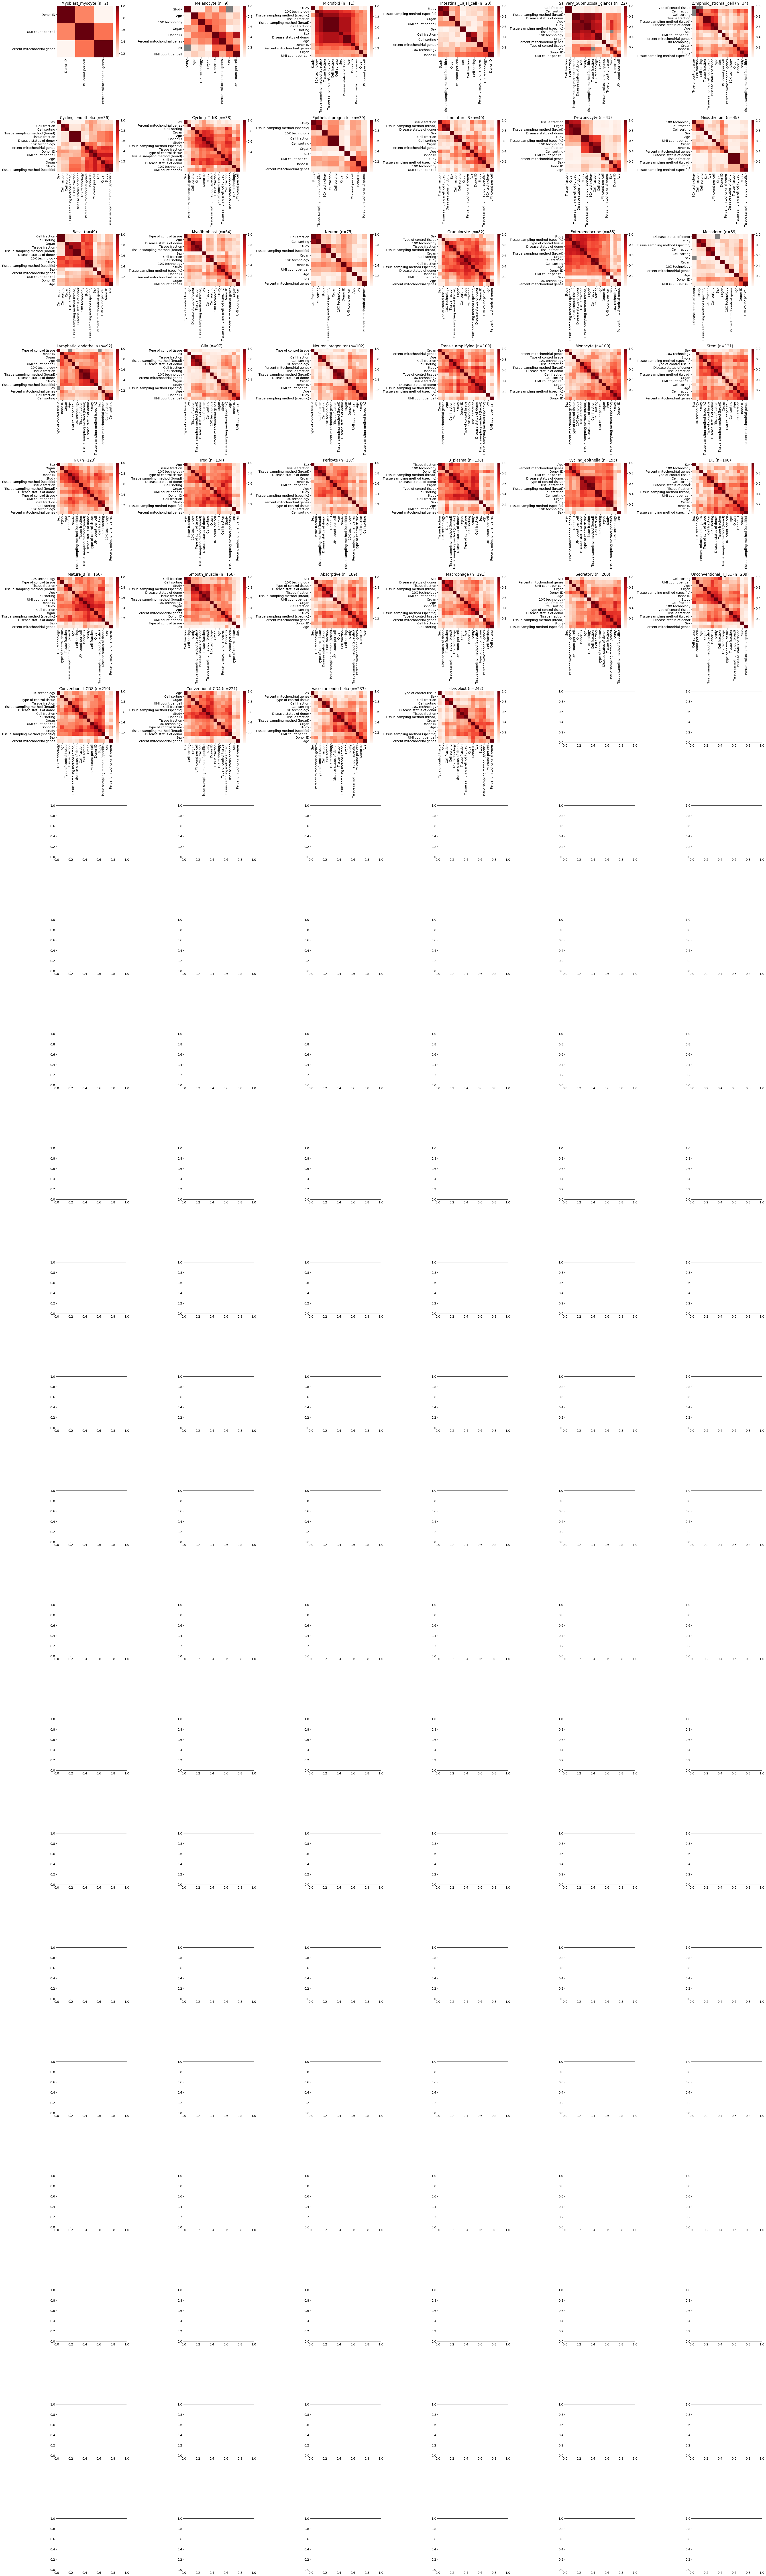

In [68]:
n_cols = 6
n_rows = 23 #137 fine grained cell types
figwidth = 8 * n_cols
figheight = 7 * n_rows
fz = 14
with plt.rc_context(
    {
        "xtick.labelsize": fz,
        "ytick.labelsize": fz,
        "axes.labelsize": fz,
        "font.size": fz,
    }
):
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(figwidth, figheight))
    #     constrained_layout=True,

    # gs = GridSpec(n_rows, n_cols, figure=fig)
    fig_count = 0
    axes = dict()
    for subset in n_samples_per_ct.index:
        cov_corrs = cov_corrs_ct[subset]
        # extract max number of samples included for the cell type:
        # (max, becaue it is not the same for every covariate)
        n_samples = str(int(n_samples_per_ct[subset]))
        # fill in second half (below diagonal):
        for row_n, row in enumerate(cov_corrs.index):
            for col_n, col in enumerate(cov_corrs.columns[row_n + 1 :]):
                cov_corrs.loc[col, row] = cov_corrs.loc[row, col]
        row = int(np.floor(fig_count / n_cols))
        col = fig_count % n_cols
        # remove rows/columns with nan only
        # (i.e. variables that had 0 variance in that cell type):
        rows_to_remove = np.where(
            pd.isnull(cov_corrs).sum(axis=0) == cov_corrs.shape[0]
        )
        row_names_to_remove = cov_corrs.index[rows_to_remove]
        cov_corrs.drop(
            index=row_names_to_remove, columns=row_names_to_remove, inplace=True
        )
        # mask remaining nan values (don't think they're there)
        mask = pd.isnull(cov_corrs)
        c = sns.clustermap(data=cov_corrs.fillna(0), mask=mask)
        order = c.dendrogram_row.reordered_ind
        plt.close()
        ind = cov_corrs.index[order]
        cov_corrs = cov_corrs.loc[ind, ind]
        mask = cov_corrs.isnull()
        cov_corrs.fillna(0, inplace=True)
        # clean up column + row names:
        cov_corrs_clean = cov_corrs.rename(columns=col_remapper, index=col_remapper)
        mask_clean = mask.rename(columns=col_remapper, index=col_remapper)
        sns.heatmap(data=cov_corrs_clean, ax=ax[row, col], mask=mask_clean, cmap=cmap)
        ax[row, col].set_title(f"{subset} (n={n_samples})")
        fig_count += 1
        plt.tight_layout()
    plt.show()
    plt.close()
    FIGURES["_correlations_between_covariates_sample_level"] = fig

In [71]:
for figname, fig in FIGURES.items():
    print("saving", figname)
    fig.savefig(
        os.path.join(dir_figures, f"{figname}.pdf"),
        bbox_inches="tight",
        dpi=140,
        transparent=True,
    )
    plt.close()

saving supplementaryFraction_of_total_variance_explained_per_covariate_integrated_emb
saving _mean_var_expl_per_cov_ct_vs_nsample
saving _bio_over_tech_var_explained_vs_nsamples
saving _sampl_meth_entr_vs_varexpl
saving _correlations_between_covariates_sample_level
